In [1]:
import os
import re
import time
import math
import json

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from skimage.transform import resize

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms, datasets, utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
device = torch.device("cpu")

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

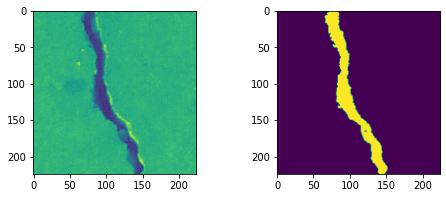

In [8]:
class CustomDataSet(Dataset):
    def __init__(self, root, shape):
        self.ROOT = root
        self.shape = shape
        
        self.images = sorted(os.listdir(os.path.join(root, "Sub")))[:-1]#read_images(root + "/images")
        with open(os.path.join(root, "masks.json"), "r") as file:
            self.labels = {int(k):np.array(v) for k,v in json.load(file).items()}
        del(self.labels[100])
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = plt.imread(os.path.join(self.ROOT, "Sub", self.images[idx]))
        img = resize(img, self.shape)
        img = np.dot(img[... , :3], [.21, .72, .07]).reshape(-1, *self.shape)
        label = resize(self.labels[idx], self.shape).reshape(-1, *self.shape)

        return img, label
    
root_dir = "/home/becode/Projects/Skyebase/concrete/Auto"
dataset = CustomDataSet(root_dir, (224, 224))
loader = DataLoader(dataset, batch_size=20, num_workers=0)

dataiter = iter(loader)
images, labels = dataiter.next()

fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].imshow(images[0][0])
ax[1].imshow(labels[0][0])
plt.show()

In [13]:
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## ENCODER
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  #(depth from 3 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1) #(depth from 16 --> 4), 3x3 kernels
        self.pool = nn.MaxPool2d(2, 2) #reduce x-y dims by two; kernel and stride of 2
        
        ## DECODER
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.t_conv2(x))
                
        return x

# initialize the NN
model = ConvAutoencoder().double()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [14]:
# specify loss function
criterion = nn.BCELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.008)

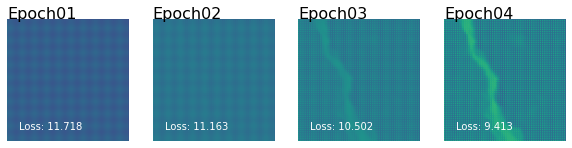

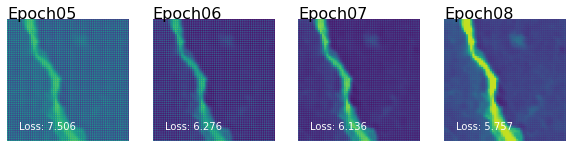

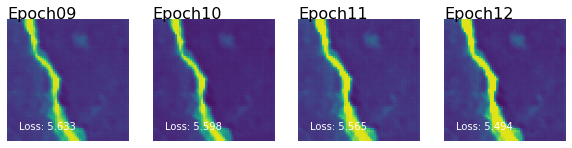

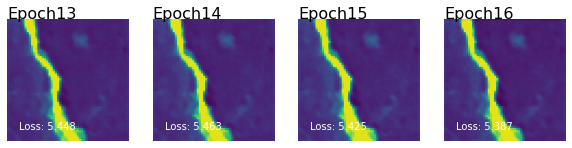

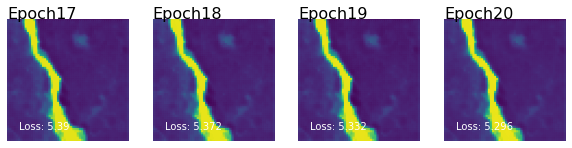

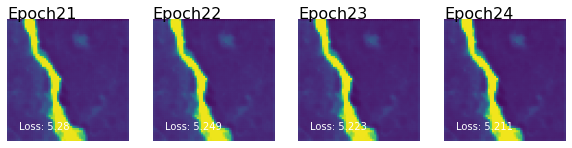

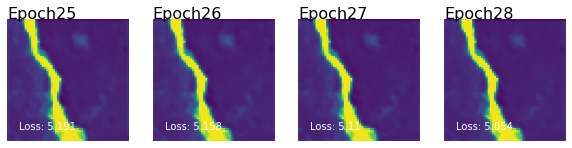

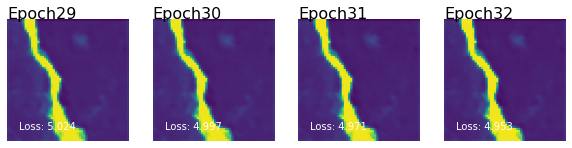

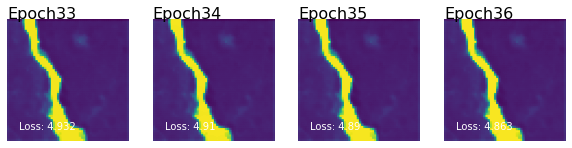

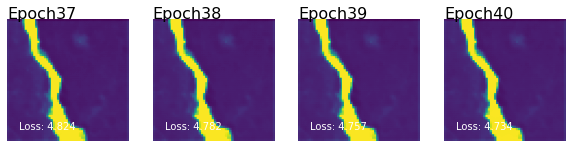

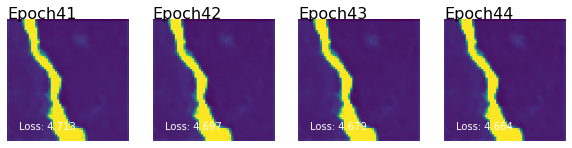

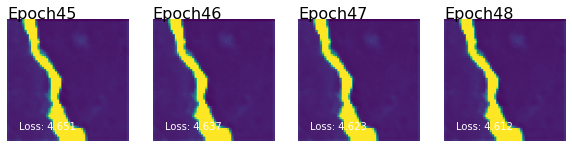

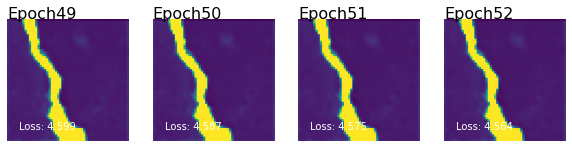

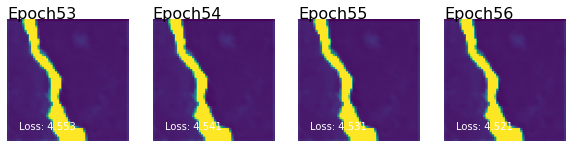

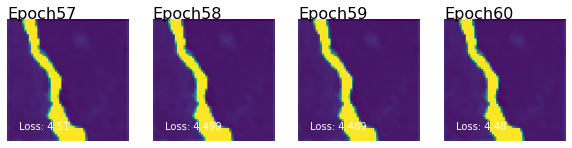

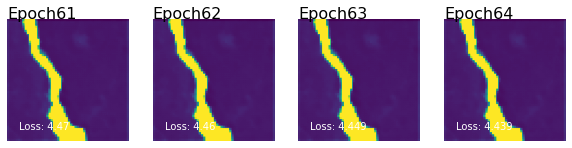

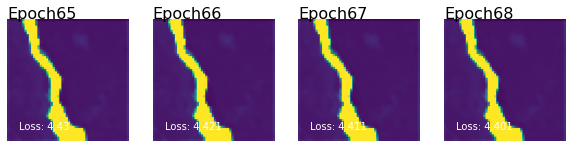

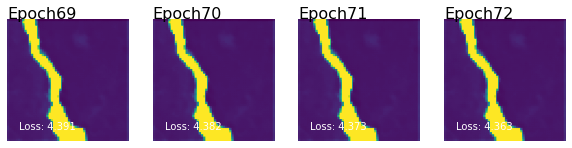

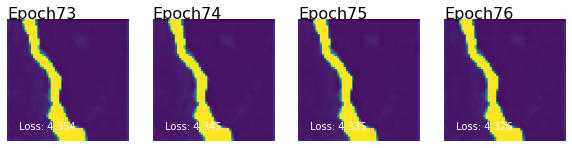

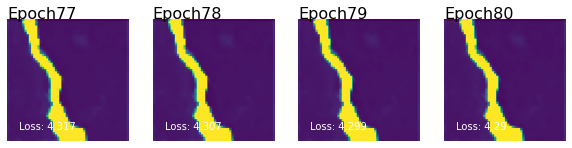

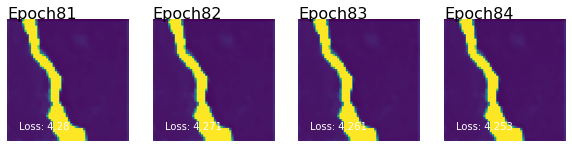

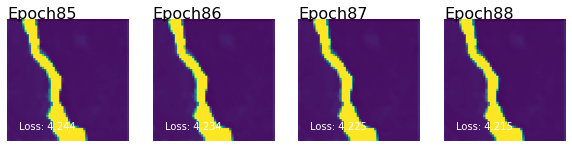

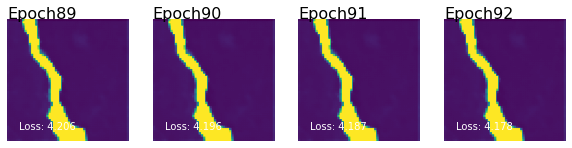

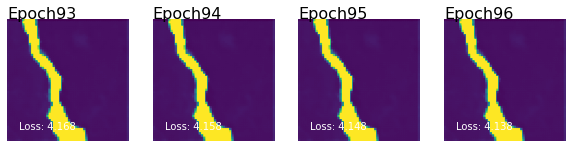

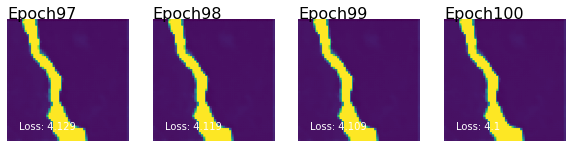

In [15]:
n_epochs = 100
outputs = None
for epoch in range(n_epochs):
    train_loss = 0.0
    
    length = len(loader)
    tenth = length//10
    for i, (images, labels) in enumerate(loader):
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images.double())
        # calculate the loss
        loss = criterion(outputs, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
        
    train_loss = train_loss/length
    if epoch%4==0: fig, ax = plt.subplots(1,4, figsize=(10,3))
    draw = torch.detach(outputs[0]).numpy()
    draw = np.einsum("CXY->XYC", draw)
    ax[epoch%4].set_axis_off()
    ax[epoch%4].imshow(draw)
    ax[epoch%4].text(0, 1.01, fontsize=16, transform=ax[epoch%4].transAxes, s=f"Epoch{epoch+1:02}")
    ax[epoch%4].text(.1, .1, color="w", transform=ax[epoch%4].transAxes, s=f"Loss: {round(train_loss, 3)}")
    if epoch%4==3: plt.show()
        
    #torch.save(model.state_dict(), f"models/crack_mask_c_{epoch+1:02}.torch")
    
    #print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [ ]:
model = ConvAutoencoder()
model.load_state_dict(torch.load(f"models/crack_mask_c_90.torch"))
model.eval()
model.double()

dataiter = iter(loader)
images, targets = dataiter.next()
predict = model(images.double())

for i, im in enumerate(images):
    fig, ax = plt.subplots(1,3,figsize=(11,3))
    ax[0].imshow(im[0])
    ax[1].imshow(torch.detach(predict[i][0]).numpy())
    ax[2].imshow(targets[i][0])

In [17]:
draw = list(map(lambda m: torch.detach(m).numpy(), outputs))
draw_xyc = list(map(lambda m: np.einsum("CXY->XYC", m), draw))

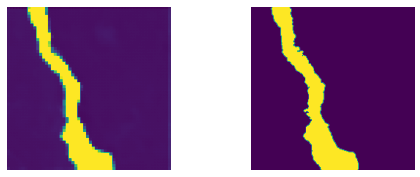

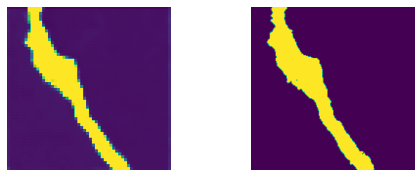

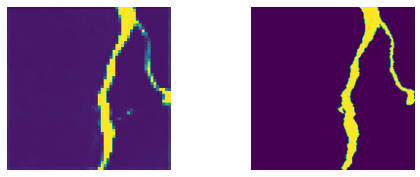

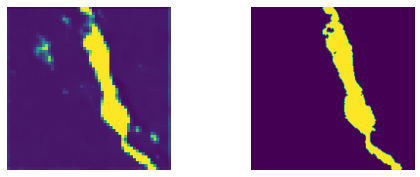

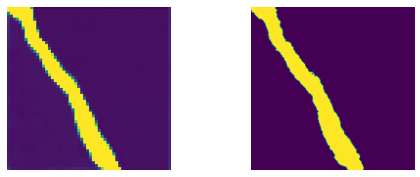

In [19]:
for i, img in enumerate(draw_xyc):
    if i==5: break
    
    fig, ax = plt.subplots(1,2,figsize=(8,3))
    [ax.set_axis_off() for ax in ax]
    
    ax[0].imshow(img)
    ax[1].imshow(labels[i][0])
    plt.show()